In [2]:
import pandas as pd
import os
import graph_tool.all as gt
import h3

In [23]:
path = 'subte_gtfs'
# Cargar GTFS
stops = pd.read_csv(os.path.join(path, "stops.txt"))
stop_times = pd.read_csv(os.path.join(path, "stop_times.txt"))
trips = pd.read_csv(os.path.join(path,"trips.txt"))
routes = pd.read_csv(os.path.join(path,"routes.txt"))

In [24]:
# 1. Secuencia de stops por trip
stop_sequences = stop_times.sort_values(['trip_id', 'stop_sequence']) \
    .groupby('trip_id')['stop_id'].apply(tuple).reset_index()

# 2. Añadir info de ruta
stop_sequences = stop_sequences.merge(trips.loc[trips.direction_id == 0,['trip_id', 'route_id']], on='trip_id')

# 3. Quitar duplicados por (route_id, secuencia)
unique_sequences = stop_sequences.drop_duplicates(subset=['route_id', 'stop_id'])

# Generar enlaces consecutivos
edges = []
for trip_id, group in unique_sequences.groupby('trip_id'):
    group = group.reset_index(drop=True)
    route_id = group.route_id.values[0]
    nodes = group.stop_id.values[0]
    if len(nodes) > 2:
        for i, j in zip(nodes[:-1], nodes[1:]):
            edges.append((i, j, route_id, trip_id))

edges_df = pd.DataFrame(edges, columns=['nodo_i', 'nodo_j', 'name', 'trip'])

# Opcional: asociar nombres de paradas y rutas
edges_df = edges_df.merge(stops[['stop_id', 'stop_name']], left_on='nodo_i', right_on='stop_id', how='left') \
                   .rename(columns={'stop_name': 'nombre_i'}) \
                   .drop(columns=['stop_id'])

edges_df = edges_df.merge(stops[['stop_id', 'stop_name']], left_on='nodo_j', right_on='stop_id', how='left') \
                   .rename(columns={'stop_name': 'nombre_j'}) \
                   .drop(columns=['stop_id'])

edges_df = edges_df.merge(routes[['route_id', 'route_long_name']], left_on='name', right_on='route_id', how='left') \
                   .drop(columns=['route_id'])



In [ ]:
res = 10
stops.loc[:,'cell'] = stops.apply(lambda x: h3.latlng_to_cell(x.stop_lat, x.stop_lon,res), axis = 1)

edges_df.loc[:,'cell_i'] = edges_df.merge(stops[['stop_id','cell']], left_on = 'nodo_i', right_on = 'stop_id').cell
edges_df.loc[:,'cell_j'] = edges_df.merge(stops[['stop_id','cell']], left_on = 'nodo_j', right_on = 'stop_id').cell

In [38]:
nodes2int = pd.Series({n : i for n, i in enumerate(set(edges_df.cell_i).union(set(edges_df.cell_j)))}).reset_index()
nodes2int.rename({'index' : 'node_int', 0 : 'node_id'}, axis = 1, inplace=True)


edges_df.loc[:,'int_i'] = edges_df.merge(nodes2int, left_on = 'cell_i', right_on = 'node_id').node_int
edges_df.loc[:,'int_j'] = edges_df.merge(nodes2int, left_on = 'cell_j', right_on = 'node_id').node_int

In [39]:
g = gt.Graph(edges_df[['int_i', 'int_j', 'name', 'trip']].values.tolist(), eprops = [('name','object'), ('trip', 'object')], directed=False)
gt.remove_self_loops(g)

In [40]:
pos = g.new_vertex_property('vector<double>')
for v in g.vertices():
    lat, lon = h3.cell_to_latlng(nodes2int.loc[nodes2int.node_int == v].node_id.values[0])
    pos[v] = (lon, -lat)

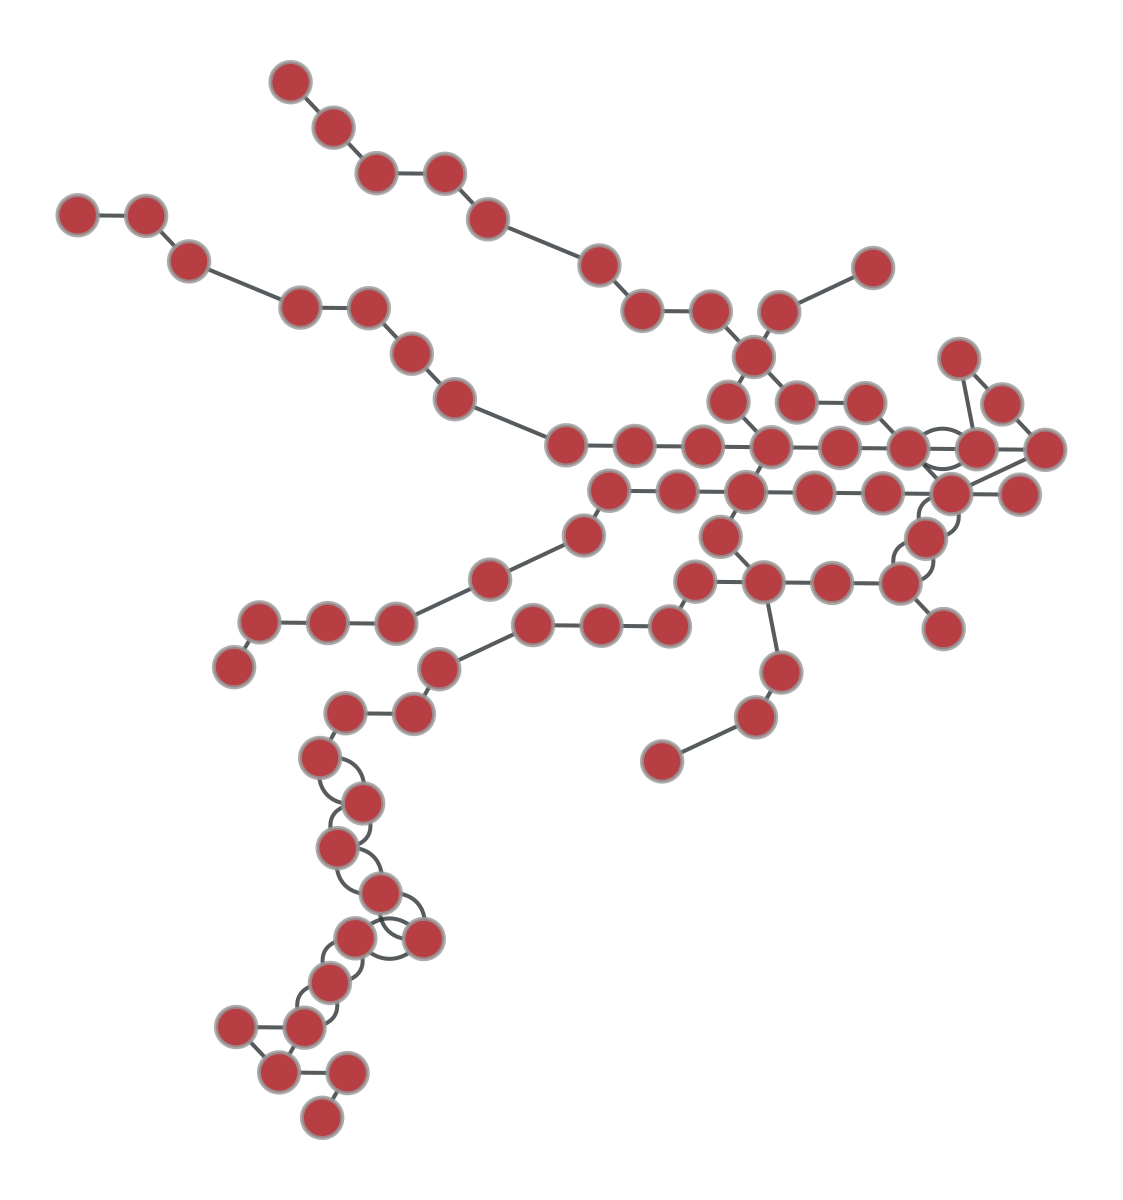

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9658f524b0, at 0x7f9657d549b0>

In [41]:
gt.graph_draw(g, pos=pos)

In [30]:
nodes2int.node_id.apply(h3.cell_area).mean() * 1000 ** 2

np.float64(10452.969472280525)

In [31]:
g.num_vertices()

106